In [1]:
pip install joblib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import joblib
import math
import random
import numpy as np
import pandas as pd
import nltk
nltk.data.path.append('.')

In [3]:
import os
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_sm")
# Define file paths and corresponding authors
file_paths_and_authors = [
    ("Data/CharlesDickens_1.txt", "Charles Dickens"),
    ("Data/CharlesDickens_2.txt", "Charles Dickens"),
    ("Data/CharlesDickens_3.txt", "Charles Dickens"),
    ("Data/JaneAusten_1.txt", "Jane Austen"),
    ("Data/JaneAusten_2.txt", "Jane Austen"),
    ("Data/JaneAusten_3.txt", "Jane Austen"),
    ("Data/WilliamShakespeare_1.txt", "William Shakespeare"),
    ("Data/WilliamShakespeare_2.txt", "William Shakespeare"),
    ("Data/WilliamShakespeare_3.txt", "William Shakespeare")
]
nlp.max_length = 2000000

# Load and preprocess texts
def load_texts(file_paths_and_authors):
    texts = []
    authors = []
    for file_path, author in file_paths_and_authors:
        with open(file_path, "r", encoding="utf-8") as file:
            texts.append(file.read())
            authors.append(author)
    return texts, authors
# Combine texts and authors into a list of tuples
texts, authors = load_texts(file_paths_and_authors)
combined_texts_and_authors = list(zip(texts, authors))


In [4]:
import re
from collections import Counter

# Text cleaning function
def clean_text(text):
    patterns_to_remove = [
        r"The Project Gutenberg eBook.*?CONTENTS",
        r"Preface.*?(?=CHAPTER I|$)",
        r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*\*\*\*"
    ]
    for pattern in patterns_to_remove:
        text = re.sub(pattern, "", text, flags=re.DOTALL)
    return text

# Process each text and associate with author
processed_texts = []
processed_authors = []
for text, author in combined_texts_and_authors:
    cleaned_text = clean_text(text)
    processed_texts.append(cleaned_text)
    processed_authors.append(author)

# Combine all texts into a single string
combined_text = " ".join(processed_texts)
combined_authors = " ".join(processed_authors)
print(f"Combined text length: {len(combined_text)}")


Combined text length: 10689861


In [5]:
# Remove punctuations
clean_data = re.sub(r'[^\w\s]', '', combined_text)
print(f"Length of text with punctuations: {len(combined_text)}")
print(f"Length of text without punctuations: {len(clean_data)}")

data_words = clean_data.split()
clean_data_count = Counter(data_words)
dataframe = pd.DataFrame(clean_data_count.items(), columns=['Words', 'Frequency'])
dataframe_sorted = dataframe.sort_values(by='Frequency', ascending=False)
most_fifty = dataframe_sorted.head(50)
print(most_fifty)


Length of text with punctuations: 10689861
Length of text without punctuations: 10208798
      Words  Frequency
10      the      64321
9       and      51166
1         I      45022
41       to      44535
34       of      41765
43        a      32500
14       in      26779
355     you      22155
246    that      20821
854      my      18879
36       it      18403
182     his      16349
66     with      16198
238      is      16107
38      not      15289
948      me      14431
287      he      13822
39       be      13672
77      for      13182
525     her      12842
492     was      12744
25       as      12367
108    have      11774
950     him      10788
256     And      10054
115    this       9572
101      at       9110
850    your       8856
148      on       8775
49       so       8625
28      had       8309
29      but       7914
201     all       7662
173      by       7367
236     The       7319
795    will       7181
529     she       6704
243     are       5937
32     from   

In [6]:

# Function to split text into smaller chunks
def split_text_into_chunks(text, max_length):
    return [text[i:i + max_length] for i in range(0, len(text), max_length)]

# Split the clean data into manageable chunks for spaCy
max_length = 1000000  # spaCy's default maximum length
text_chunks = split_text_into_chunks(clean_data, max_length)

people_names = set()
places = set()

# Process each chunk separately
for chunk in text_chunks:
    doc = nlp(chunk)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            people_names.add(ent.text)
        elif ent.label_ == "GPE":
            places.add(ent.text)

print("People Names:", people_names)
print("Places:", places)


In [ ]:
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree

# Function to split text into chunks
def split_text(text, chunk_size):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Function to associate each chunk with an author
def split_text_with_author(text, author, chunk_size):
    chunks = split_text(text, chunk_size)
    return [(chunk, author) for chunk in chunks]

# Split texts into chunks and label with authors
chunk_size = 500
chunks_and_authors = []
for text, author in zip(processed_texts, processed_authors):
    chunks_and_authors.extend(split_text_with_author(text, author, chunk_size))

# Extract proper names using spaCy and NLTK
def extract_proper_names_spacy(text):
    doc = nlp(text)
    proper_names = set()
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            proper_names.add(ent.text)
    return proper_names

def extract_proper_names_nltk(text):
    proper_names = set()
    for chunk in ne_chunk(pos_tag(word_tokenize(text))):
        if isinstance(chunk, Tree) and chunk.label() == 'PERSON':
            proper_names.add(' '.join([c[0] for c in chunk]))
    return proper_names

def process_chunk(chunk, author):
    proper_names_spacy = extract_proper_names_spacy(chunk)
    proper_names_nltk = extract_proper_names_nltk(chunk)
    has_proper_names = 'T' if proper_names_spacy or proper_names_nltk else 'F'
    return chunk, has_proper_names, author

results = [process_chunk(chunk, author) for chunk, author in chunks_and_authors]

texts, proper_names_labels, authors_labels = zip(*results)
df = pd.DataFrame({
    'Chunks': texts,
    'HasProperNames': proper_names_labels,
    'Author': authors_labels
})

print(df)




                                                  Chunks HasProperNames  \
0      ﻿\n\n            CHAPTER I\n\nIn Chancery\n\n\...              T   
1      snowflakes—gone into mourning, one might imagi...              F   
2      nts tenaciously to the pavement, and\naccumula...              T   
3      all boats. Fog in the eyes and throats of anci...              F   
4      in divers places in the streets, much as\nthe ...              T   
...                                                  ...            ...   
21380  tax exempt\nstatus with the IRS.\n\nThe Founda...              F   
21381  r state\nvisit www.gutenberg.org/donate.\n\nWh...              F   
21382  ck the Project Gutenberg web pages for current...              T   
21383  \ndistributed Project Gutenberg™ eBooks with o...              T   
21384   Gutenberg™,\nincluding how to make donations ...              T   

                    Author  
0          Charles Dickens  
1          Charles Dickens  
2          C

In [ ]:
df['Author'].value_counts()

Author
William Shakespeare    11330
Charles Dickens         7483
Jane Austen             2572
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Downsample the classes to 2500 samples each
df_balanced = df.groupby('Author', group_keys=False).apply(lambda x: x.sample(2500, random_state=42)).reset_index(drop=True)

# Check the balanced distribution of the authors
print("Balanced author distribution:\n", df_balanced['Author'].value_counts())

csv_file_path = "Data/BalancedAuthor_dataset.csv"
df_balanced.to_csv(csv_file_path, index=False)

Balanced author distribution:
 Author
Charles Dickens        2500
Jane Austen            2500
William Shakespeare    2500
Name: count, dtype: int64


C:\Users\harin\AppData\Local\Temp\ipykernel_18628\3729476225.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Author', group_keys=False).apply(lambda x: x.sample(2500, random_state=42)).reset_index(drop=True)


In [ ]:
df_balanced = pd.read_csv(csv_file_path)
# Encode the author labels
label_encoder = LabelEncoder()
df_balanced['AuthorEncoded'] = label_encoder.fit_transform(df_balanced['Author'])

# Convert labels to numerical values
df_balanced['HasProperNames'] = df_balanced['HasProperNames'].map({'T': 1, 'F': 0})

# Define features and target
X = df_balanced['Chunks']
y = df_balanced['AuthorEncoded']

# Convert text data to numerical data using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Train the classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9586666666666667


In [ ]:
# Load and preprocess the validation dataset
validation_file_paths_and_authors = [
    ("Data/CharlesDickens.txt", "Charles Dickens"),
    ("Data/JaneAusten.txt", "Jane Austen"),
    ("Data/WilliamShakespeare.txt", "William Shakespeare")
]

validation_texts, validation_authors = load_texts(validation_file_paths_and_authors)

# Clean validation texts
processed_validation_texts = []
processed_validation_authors = []
for text, author in zip(validation_texts, validation_authors):
    cleaned_text = clean_text(text)
    processed_validation_texts.append(cleaned_text)
    processed_validation_authors.append(author)

# Split validation texts into chunks
validation_chunks_and_authors = []
for text, author in zip(processed_validation_texts, processed_validation_authors):
    validation_chunks_and_authors.extend(split_text_with_author(text, author, chunk_size))

# Predict the author for each chunk in the validation dataset
def predict_author(chunk):
    clean_chunk = re.sub(r'[^\w\s]', '', chunk)
    chunk_vectorized = vectorizer.transform([clean_chunk])
    predicted_label_encoded = classifier.predict(chunk_vectorized)
    predicted_author = label_encoder.inverse_transform(predicted_label_encoded)
    return predicted_author[0]

validation_predictions = []
validation_actual = []
for chunk, actual_author in validation_chunks_and_authors:
    chunk_vectorized = vectorizer.transform([chunk])
    predicted_author = label_encoder.inverse_transform(classifier.predict(chunk_vectorized))[0]
    validation_predictions.append(predicted_author)
    validation_actual.append(actual_author)
     
# Display the predictions
for actual_author, predicted_author in zip(validation_actual, validation_predictions):
    print(f"Actual Author: {actual_author}, Predicted Author: {predicted_author}")

Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Charles Dickens
Actual Author: Charles Dickens, Predicted Author: Charles Dickens
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Charles Dickens
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Jane Austen
Actual Author: Charles Dickens, Predicted Author: Charles 

Confusion Matrix:
 [[1518  302    5]
 [   7 1413    0]
 [   0   40  355]]


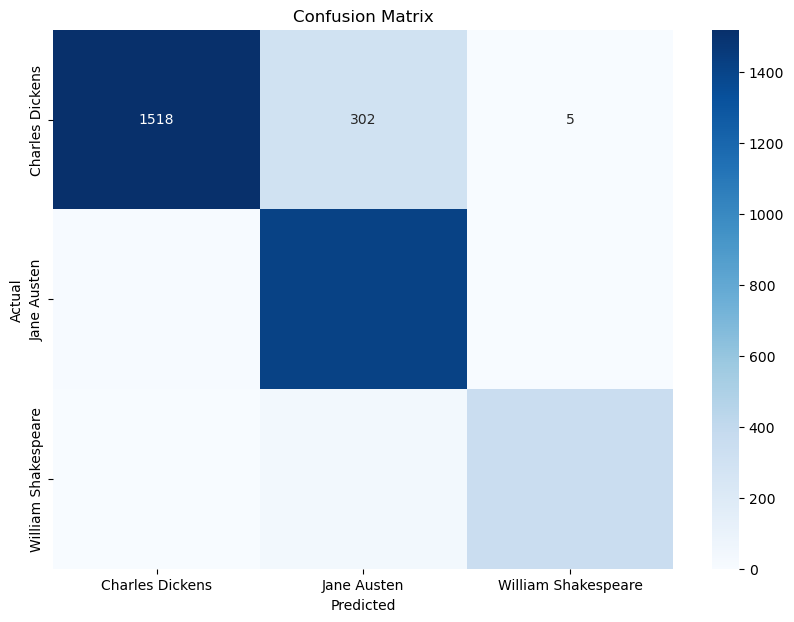

Classification Report:
                     precision    recall  f1-score   support

    Charles Dickens       1.00      0.83      0.91      1825
        Jane Austen       0.81      1.00      0.89      1420
William Shakespeare       0.99      0.90      0.94       395

           accuracy                           0.90      3640
          macro avg       0.93      0.91      0.91      3640
       weighted avg       0.92      0.90      0.90      3640



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model using confusion matrix and classification report
conf_matrix = confusion_matrix(validation_actual, validation_predictions, labels=label_encoder.classes_)
class_report = classification_report(validation_actual, validation_predictions, target_names=label_encoder.classes_)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(class_report)

SVM Classification Report:
                     precision    recall  f1-score   support

    Charles Dickens       0.97      0.95      0.96       527
        Jane Austen       0.94      0.97      0.96       492
William Shakespeare       0.99      0.98      0.99       481

           accuracy                           0.97      1500
          macro avg       0.97      0.97      0.97      1500
       weighted avg       0.97      0.97      0.97      1500

SVM Confusion Matrix:
Confusion Matrix:
 [[503  21   3]
 [ 13 479   0]
 [  2   7 472]]


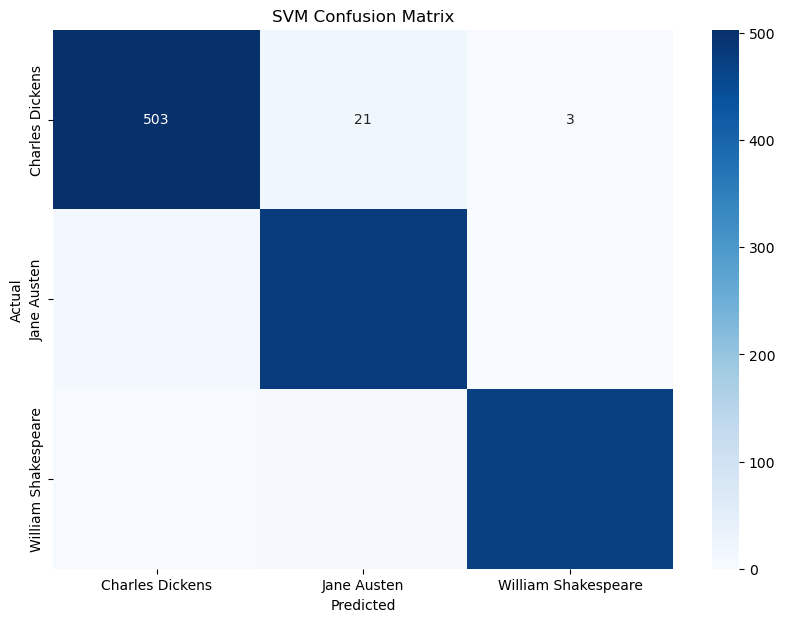

Random Forest Classification Report:
                     precision    recall  f1-score   support

    Charles Dickens       0.89      0.85      0.87       527
        Jane Austen       0.83      0.90      0.86       492
William Shakespeare       0.96      0.94      0.95       481

           accuracy                           0.89      1500
          macro avg       0.89      0.89      0.89      1500
       weighted avg       0.89      0.89      0.89      1500

Random Forest Confusion Matrix:
Confusion Matrix:
 [[447  67  13]
 [ 43 441   8]
 [ 10  21 450]]


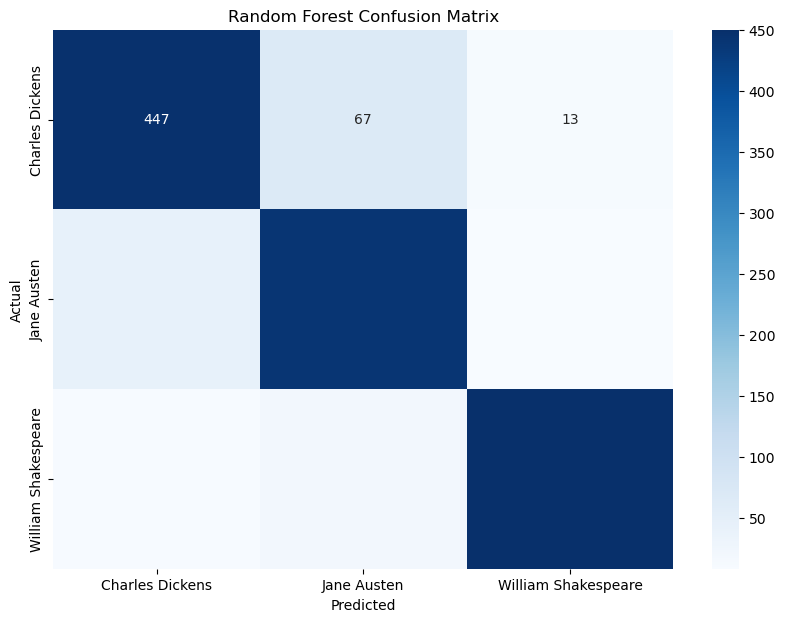

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Define the classifiers
svm_classifier = SVC(kernel='linear', random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Make predictions with the SVM classifier
svm_predictions = svm_classifier.predict(X_test)

# Make predictions with the Random Forest classifier
rf_predictions = rf_classifier.predict(X_test)

# Decode the predictions back to author names
svm_predictions_decoded = label_encoder.inverse_transform(svm_predictions)
rf_predictions_decoded = label_encoder.inverse_transform(rf_predictions)


# SVM Evaluation
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions, target_names=label_encoder.classes_))

print("SVM Confusion Matrix:")
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
print("Confusion Matrix:\n", svm_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

# Random Forest Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions, target_names=label_encoder.classes_))

print("Random Forest Confusion Matrix:")
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix:\n", rf_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


Naive Bayes Training Accuracy: 0.984
SVM Training Accuracy: 0.9921666666666666
Random Forest Training Accuracy: 1.0


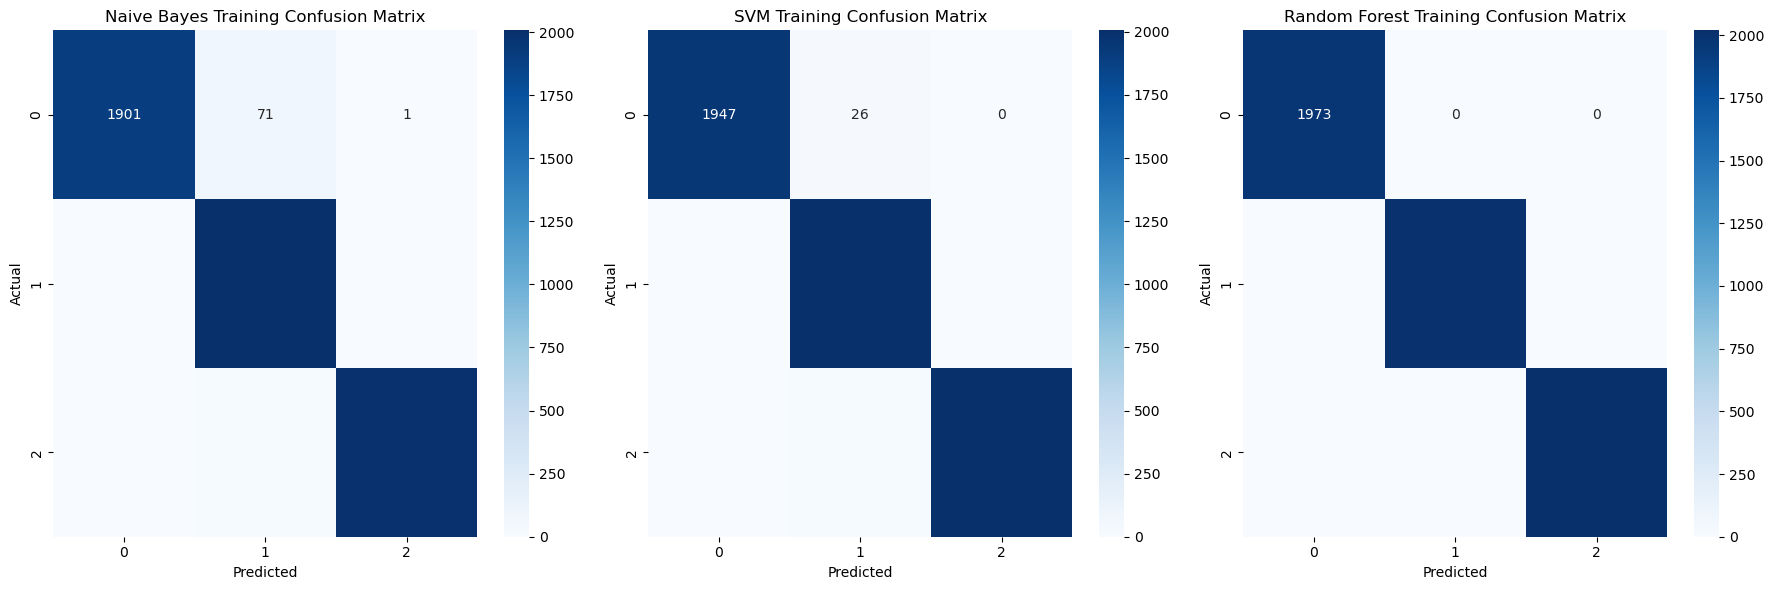

In [ ]:
# Predict the labels for the training set
y_train_pred_nb = classifier.predict(X_train)
y_train_pred_svm = svm_classifier.predict(X_train)
y_train_pred_rf = rf_classifier.predict(X_train)

# Calculate and print accuracy for all models on the training set
accuracy_train_nb = accuracy_score(y_train, y_train_pred_nb)
accuracy_train_svm = accuracy_score(y_train, y_train_pred_svm)
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"Naive Bayes Training Accuracy: {accuracy_train_nb}")
print(f"SVM Training Accuracy: {accuracy_train_svm}")
print(f"Random Forest Training Accuracy: {accuracy_train_rf}")

# Generate confusion matrices for all models on the training set
conf_matrix_train_nb = confusion_matrix(y_train, y_train_pred_nb)
conf_matrix_train_svm = confusion_matrix(y_train, y_train_pred_svm)
conf_matrix_train_rf = confusion_matrix(y_train, y_train_pred_rf)

# Plot confusion matrices
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train_nb, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.title('Naive Bayes Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_train_svm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('SVM Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_train_rf, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title('Random Forest Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

Naive Bayes Cross-Validation Accuracy: 0.9658333333333333
SVM Cross-Validation Accuracy: 0.9663333333333334
Random Forest Cross-Validation Accuracy: 0.8981666666666667


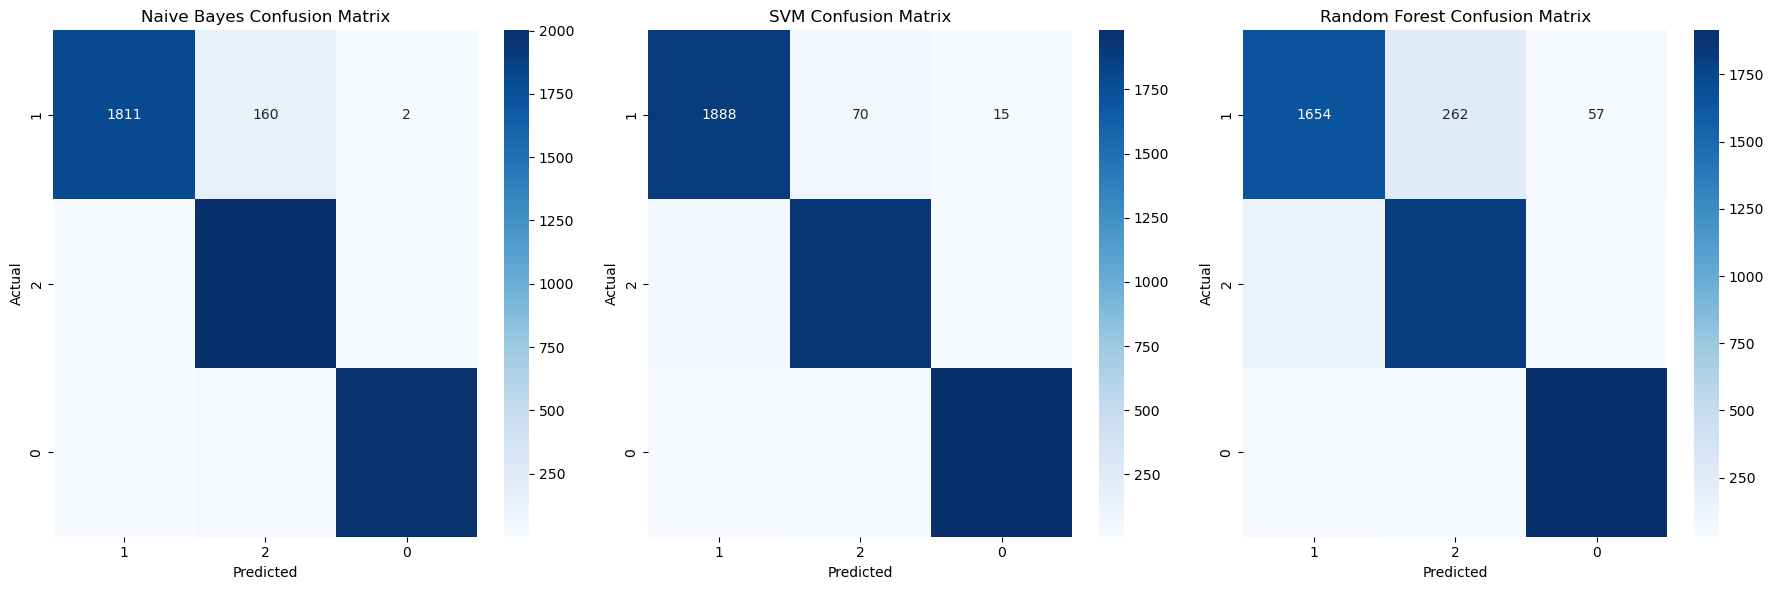

In [ ]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Initialize the models
nb_model = MultinomialNB()
svm_model = SVC()
rf_model = RandomForestClassifier()

# Define the k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get predictions
y_pred_nb = cross_val_predict(nb_model, X_train, y_train, cv=kf)
y_pred_svm = cross_val_predict(svm_model, X_train, y_train, cv=kf)
y_pred_rf = cross_val_predict(rf_model, X_train, y_train, cv=kf)

# Calculate and print accuracy for all models
accuracy_nb = accuracy_score(y_train, y_pred_nb)
accuracy_svm = accuracy_score(y_train, y_pred_svm)
accuracy_rf = accuracy_score(y_train, y_pred_rf)
print(f"Naive Bayes Cross-Validation Accuracy: {accuracy_nb}")
print(f"SVM Cross-Validation Accuracy: {accuracy_svm}")
print(f"Random Forest Cross-Validation Accuracy: {accuracy_rf}")

# Generate confusion matrices for all models
conf_matrix_nb = confusion_matrix(y_train, y_pred_nb)
conf_matrix_svm = confusion_matrix(y_train, y_pred_svm)
conf_matrix_rf = confusion_matrix(y_train, y_pred_rf)

# Get unique classes from the target variable
classes = y_train.unique()

# Plot confusion matrices
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [ ]:
df_new = pd.read_csv(csv_file_path)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Encode the labels
label_encoder = LabelEncoder()
df['Author'] = label_encoder.fit_transform(df['Author'])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(df['Chunks'], df['Author'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_val_tfidf = vectorizer.transform(X_val).toarray()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_tfidf, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Create datasets
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
val_dataset = TextDataset(X_val_tensor, y_val_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
input_dim = X_train_tfidf.shape[1]
hidden_dim = 100
output_dim = len(label_encoder.classes_)

# Initialize the model, loss function, and optimizer
mlp_model = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy}')

# Train and evaluate MLP
train_model(mlp_model, train_loader, criterion, optimizer)
evaluate_model(mlp_model, val_loader, criterion)


Epoch 1/5, Loss: 0.167069211602211
Epoch 2/5, Loss: 0.036935824900865555
Epoch 3/5, Loss: 0.0790427103638649
Epoch 4/5, Loss: 0.003559886245056987
Epoch 5/5, Loss: 0.00141039933077991
Validation Accuracy: 0.9787234042553191


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model, loss function, and optimizer
hidden_dim = 100
lstm_model = LSTMClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)


In [ ]:
# Reshape the input for LSTM
X_train_lstm = X_train_tensor.unsqueeze(1)
X_val_lstm = X_val_tensor.unsqueeze(1)

# Update datasets and dataloaders
train_dataset = TextDataset(X_train_lstm, y_train_tensor)
val_dataset = TextDataset(X_val_lstm, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
# Train and evaluate LSTM
train_model(lstm_model, train_loader, criterion, optimizer)
evaluate_model(lstm_model, val_loader, criterion)


Epoch 1/5, Loss: 0.07754815369844437
Epoch 2/5, Loss: 0.09217743575572968
Epoch 3/5, Loss: 0.0012858068803325295
Epoch 4/5, Loss: 0.00771399587392807
Epoch 5/5, Loss: 0.004674145020544529
Validation Accuracy: 0.9763853168108487


In [ ]:
pip install transformers datasets pandas


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install transformers[torch] accelerate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade transformers accelerate

     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     -------------------------- ----------- 30.7/43.7 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 43.7/43.7 kB 530.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
    --------------------------------------- 0.2/9.5 MB 7.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/9.5 MB 11.6 MB/s eta 0:00:01
   ------ --------------------------------- 1.6/9.5 MB 13.1 MB/s eta 0:00:01
   --------- ------------------------------ 2.3/9.5 MB 13.2 MB/s eta 0:00:01
   ------------ --------------------------- 2.9/9.5 MB 13.2 MB/s eta 0:00:01
   -------------- ------------------------- 3.5/9.5 MB 13.2 MB/s eta 0:00:01
   ----------------- ---------------------- 4.1/9.5 MB 13.3 MB/s eta 0:00:01
   -------------------- ------------------- 4.8/9.5 MB 13.2 MB/s eta 0:00:01
   ---------------------- ----------------- 5.4/9.5 MB 13.3 MB/s eta 0:00:01
   ----

In [ ]:
pip install --upgrade pyarrow

In [ ]:
pip show transformers


Name: transformers
Version: 4.44.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: c:\Users\harin\anaconda3\Lib\site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip show torch

Name: torch
Version: 2.3.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: c:\Users\harin\anaconda3\Lib\site-packages
Requires: filelock, fsspec, jinja2, mkl, networkx, sympy, typing-extensions
Required-by: accelerate, torchaudio, torchvision
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip show accelerate

Name: accelerate
Version: 0.33.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: c:\Users\harin\anaconda3\Lib\site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install torch transformers pandas


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Load the dataset from CSV
# csv_file_path = "Data/BalancedAuthor_dataset.csv"
# df_new = pd.read_csv(csv_file_path)

# # Define the labels
# labels = df_new['Author'].unique()
# label_to_id = {label: idx for idx, label in enumerate(labels)}
# id_to_label = {idx: label for label, idx in label_to_id.items()}

# # Add numerical labels to the DataFrame
# df_new['label'] = df_new['Author'].map(label_to_id)

# # Split the dataset into train and test sets
# train_texts, test_texts, train_labels, test_labels = train_test_split(
#     df_new['Chunks'].tolist(), df_new['label'].tolist(), test_size=0.2, random_state=42
# )


In [ ]:
# from transformers import AutoTokenizer

# # Load a pre-trained tokenizer
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# # Tokenize the datasets
# train_encodings = tokenizer(train_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True)


c:\Users\harin\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# import torch

# class AuthorDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['labels'] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# train_dataset = AuthorDataset(train_encodings, train_labels)
# test_dataset = AuthorDataset(test_encodings, test_labels)


In [ ]:
# from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# # Example dataset and labels
# labels = ['label1', 'label2']
# num_labels = len(labels)

# # Load a pre-trained model
# model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# # Dummy datasets
# from datasets import load_dataset
# dataset = load_dataset('glue', 'mrpc')

# # Define training arguments
# training_args = TrainingArguments(
#     output_dir='./results',          # output directory
#     evaluation_strategy="epoch",     # evaluation strategy to use
#     learning_rate=2e-5,              # learning rate
#     per_device_train_batch_size=16,  # batch size for training
#     per_device_eval_batch_size=16,   # batch size for evaluation
#     num_train_epochs=3,              # total number of training epochs
#     weight_decay=0.01,               # strength of weight decay
# )

# # Define the trainer
# trainer = Trainer(
#     model=model,                         # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                  # training arguments, defined above
#     train_dataset=dataset['train'],      # training dataset
#     eval_dataset=dataset['validation']   # evaluation dataset
# )

# # Train the model
# trainer.train()


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

  0%|          | 0/690 [00:00<?, ?it/s]

ValueError: You have to specify either input_ids or inputs_embeds

In [ ]:
# # Evaluate the model
# results = trainer.evaluate()

# # Print the evaluation results
# print(f"Accuracy: {results['eval_accuracy']}")


NameError: name 'trainer' is not defined

In [ ]:
# # Function to make predictions
# def predict(text):
#     inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
#     outputs = model(**inputs)
#     predictions = outputs.logits.argmax(dim=-1)
#     return id_to_label[predictions.item()]

# # Test the prediction function
# test_text = "I was never more surprized in my life than by Sir James’s arrival"
# predicted_author = predict(test_text)
# print(f"Predicted Author: {predicted_author}")


Predicted Author: William Shakespeare
